In [1]:
!nvcc --version
!pip install torch

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

###Base Implementation
This remains universal to all parts, with only hyperparameters changing.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#transform = transforms.Compose([transforms.ToTensor(),])

batch_size = 32 #4,8,16,32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 28277624.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*3*3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
device = torch.device('cuda:0')
#net.to(device)

In [4]:
import torch.optim as optim
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma=0.5)

In [5]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.KLDivLoss(reduction='batchmean',size_average=False)

import warnings
warnings.filterwarnings("ignore")

y_loss_train = []
y_loss_val = []

n_epochs = 10

accuracy = np.zeros(n_epochs)
accuracy_train = np.zeros(n_epochs)

for epoch in range(n_epochs):  
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        #outputs = torch.nn.functional.log_softmax(outputs,dim=1) #Both for KLDivLoss
        #loss = (criterion(outputs, labels.float().view(-1, 1)))/1e12
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss*batch_size / 50000
    #scheduler.step()  #Imp add for schedulers
    #print(optimizer.param_groups[0]["lr"])
    y_loss_train.append(epoch_loss)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}') #Inaccurate, only estimate

    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            #images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            #loss = criterion(outputs, labels.float().view(-1, 1))/1e12
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss*batch_size / 10000
    y_loss_val.append(epoch_loss)
    accuracy[epoch] = 100 * correct / total

    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            #images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            #loss = criterion(outputs, labels.float().view(-1, 1))/1e12

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy_train[epoch] = 100 * correct / total

print('Finished Training')
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

[1,  1563] loss: 1.197
[2,  1563] loss: 0.917
[3,  1563] loss: 0.805
[4,  1563] loss: 0.729
[5,  1563] loss: 0.675
[6,  1563] loss: 0.630
[7,  1563] loss: 0.592
[8,  1563] loss: 0.558
[9,  1563] loss: 0.532
[10,  1563] loss: 0.509
Finished Training


###Testing and Visualization

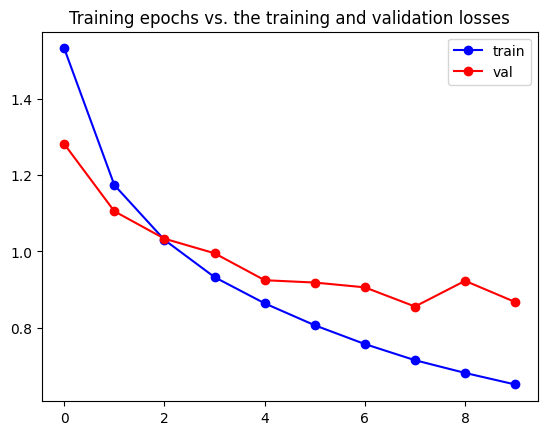

In [6]:
plt.title("Training epochs vs. the training and validation losses")
plt.plot(np.arange(n_epochs),y_loss_train,'bo-', label='train')
plt.plot(np.arange(n_epochs),y_loss_val,'ro-', label='val')
plt.legend()
plt.show()

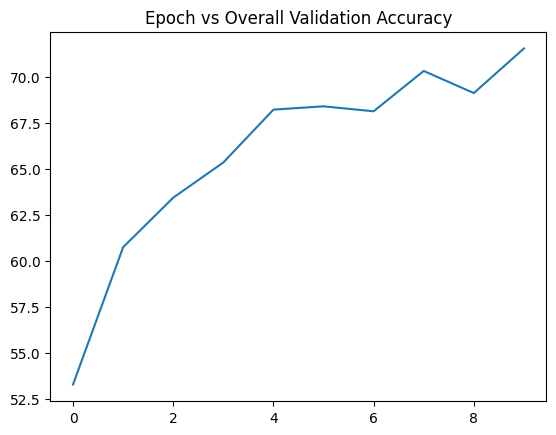

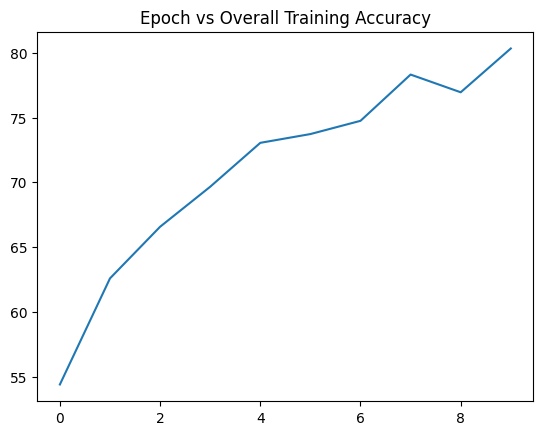

71.54
Download Path


In [7]:
plt.title("Epoch vs Overall Validation Accuracy")
plt.plot(np.arange(n_epochs),accuracy)
plt.show()
plt.title("Epoch vs Overall Training Accuracy")
plt.plot(np.arange(n_epochs),accuracy_train)
plt.show()
print(accuracy[-1])
print("Download Path")

In [8]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        #images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accur = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accur:.1f} %')

Accuracy for class: plane is 71.8 %
Accuracy for class: car   is 82.1 %
Accuracy for class: bird  is 62.9 %
Accuracy for class: cat   is 41.8 %
Accuracy for class: deer  is 73.2 %
Accuracy for class: dog   is 64.7 %
Accuracy for class: frog  is 79.8 %
Accuracy for class: horse is 74.9 %
Accuracy for class: ship  is 84.1 %
Accuracy for class: truck is 80.1 %
